In [1]:
# Importing the libraries
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import tensorflow as tf

%matplotlib inline

In [2]:
train_set = pd.read_csv('dataset/sign_mnist_train.csv')
test_set = pd.read_csv('dataset/sign_mnist_test.csv')

In [3]:
X_train = train_set.iloc[:, 1:].values
y_train = train_set.iloc[:, 0].values

X_test = test_set.iloc[:, 1:].values
y_test = test_set.iloc[:, 0].values

In [4]:
X_train = np.array([np.reshape(i, (28,28)) for i in X_train])
X_test = np.array([np.reshape(i, (28,28)) for i in X_test])

y_train = np.array(y_train).reshape(-1)
y_test = np.array(y_test).reshape(-1)

In [5]:
y_train = tf.keras.utils.to_categorical(y_train, 26)
y_test = tf.keras.utils.to_categorical(y_test, 26)

In [6]:
X_train = X_train.reshape((X_train.shape[0], 28, 28, 1))
X_test = X_test.reshape((X_test.shape[0], 28, 28, 1))

In [7]:
print('total training examples:', X_train.shape[0])
print('total validation examples:', X_test.shape[0])

total training examples: 27455
total validation examples: 7172


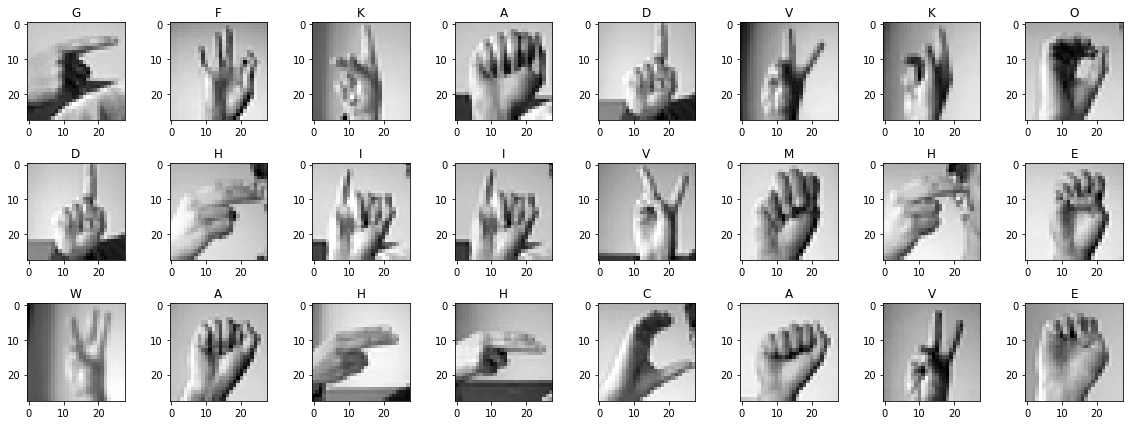

In [8]:
# Plotting our data
fig, axes = plt.subplots(3, 8, figsize=(16, 6))

for i in range(24):
    ax = axes[i//8, i%8]
    ax.imshow(X_test[i], cmap='gray')
    ax.set_title(chr(list(y_test[i]).index(max(y_test[i])) + 65))

plt.tight_layout()
plt.show()

In [9]:
# Normalizing the data
X_train  = X_train / 255.0
X_test = X_test / 255.0

In [10]:
# Initializing model and adding layers

model = tf.keras.models.Sequential([
    # Note the input shape is the desired size of the image 28x28 with 1 bytes color
    # This is the first convolution
    tf.keras.layers.Conv2D(64, (3,3), padding='same', activation='relu', input_shape=(28, 28, 1)),
    tf.keras.layers.MaxPooling2D(2, 2),
    # The second convolution
    tf.keras.layers.Conv2D(128, (3,3), padding='same', activation='relu'),
    tf.keras.layers.MaxPooling2D(2,2),
    # The third convolution
    tf.keras.layers.Conv2D(256, (3,3), padding='same', activation='relu'),
    tf.keras.layers.MaxPooling2D(2,2),
    # Dropping out 50% of the neurons
    tf.keras.layers.Dropout(0.5),
    # Flatten the results to feed into a DNN
    tf.keras.layers.Flatten(),
    # 256 neuron hidden layer
    tf.keras.layers.Dense(256, activation='relu'),
    # Dropping out 50% of the neurons
    tf.keras.layers.Dropout(0.5),
    # 26 output neurons. It will contain probabilities for each of the 26 classes.
    tf.keras.layers.Dense(26, activation='softmax')
])

In [11]:
model.compile(optimizer=tf.keras.optimizers.Adam(), 
              loss='categorical_crossentropy', 
              metrics=['accuracy'])

In [12]:
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 28, 28, 64)        640       
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 14, 14, 64)        0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 14, 14, 128)       73856     
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 7, 7, 128)         0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 7, 7, 256)         295168    
_________________________________________________________________
max_pooling2d_2 (MaxPooling2 (None, 3, 3, 256)         0         
_________________________________________________________________
dropout (Dropout)            (None, 3, 3, 256)         0

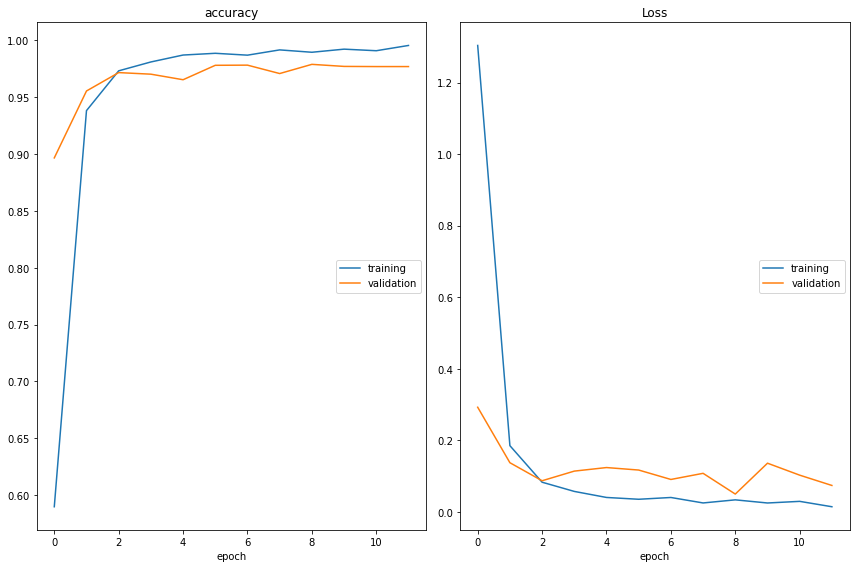

accuracy
	training         	 (min:    0.590, max:    0.996, cur:    0.996)
	validation       	 (min:    0.897, max:    0.979, cur:    0.977)
Loss
	training         	 (min:    0.014, max:    1.304, cur:    0.014)
	validation       	 (min:    0.049, max:    0.292, cur:    0.074)
Wall time: 6min 1s


In [13]:
%%time
from livelossplot.tf_keras import PlotLossesCallback

reduce_lr = tf.keras.callbacks.ReduceLROnPlateau(monitor='val_loss', 
                                                 factor=0.2, 
                                                 patience=5, 
                                                 min_lr=0.001)
checkpoint = tf.keras.callbacks.ModelCheckpoint("model_weights.h5", 
                                                save_weights_only=True, 
                                                monitor='val_accuracy',
                                                mode='max', 
                                                save_best_only=True)
callbacks = [PlotLossesCallback(), reduce_lr, checkpoint]

history = model.fit(
    X_train,
    y_train,
    epochs = 12,
    batch_size = 32,
    steps_per_epoch = X_train.shape[0] // 32,
    callbacks = callbacks,
    validation_data = (X_test, y_test),
    validation_steps = X_test.shape[0] // 32
)

In [14]:
score = model.evaluate(X_test, y_test, verbose = 0) 

print('Test loss:', score[0]) 
print('Test accuracy:', score[1])

Test loss: 0.07352587580680847
Test accuracy: 0.9769938588142395


In [15]:
# Saving trained model
model.save('model.h5')